/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Class-to-index mapping: {'fractured': 0, 'not_fractured': 1}
Training data size: 6109
Validation data size: 823
Test data size: 498
Using device: cuda


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Training Loss: 0.1605


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 90.89%
Saved the best model so far.
Epoch 2/10, Training Loss: 0.0417


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 89.31%
Epoch 3/10, Training Loss: 0.0372


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 96.48%
Saved the best model so far.
Epoch 4/10, Training Loss: 0.0305


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 97.57%
Saved the best model so far.
Epoch 5/10, Training Loss: 0.0171


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 97.21%
Epoch 6/10, Training Loss: 0.0472


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 94.53%
Epoch 7/10, Training Loss: 0.0104


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 98.42%
Saved the best model so far.
Epoch 8/10, Training Loss: 0.0257


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 97.57%
Epoch 9/10, Training Loss: 0.0098


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 97.21%
Epoch 10/10, Training Loss: 0.0022


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 98.06%
Test Accuracy: 98.80%
New Test data size: 778
New Test Accuracy (All Fractured): 94.60%


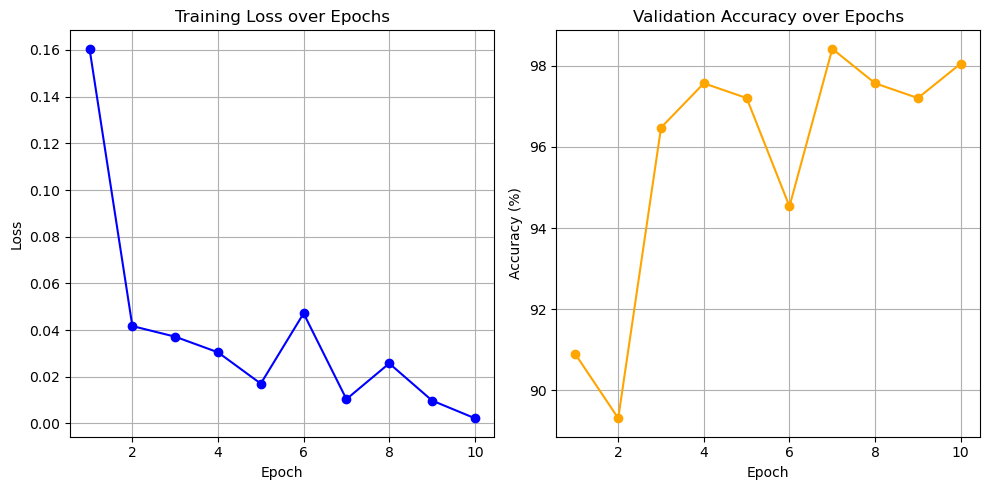

In [1]:
import os
import matplotlib.pyplot as plt  # For plotting
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        # List only visible directories (ignore hidden ones like .ipynb_checkpoints)
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        classes = [d for d in classes if not d.startswith(".")]  
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Filter out corrupted images
        valid_samples = []
        for path, target in self.samples:
            img = self.loader(path)
            if img is not None:
                valid_samples.append((path, target))
            else:
                print(f"Warning: Skipping corrupted file: {path}")
        self.samples = valid_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

class SingleFolderDataset(Dataset):
    def __init__(self, root, transform=None, target_class_idx=0):
        
        self.root = root
        self.paths = [os.path.join(root, f) for f in os.listdir(root) 
                      if is_valid_file(os.path.join(root, f))]
        self.transform = transform
        self.target_class_idx = target_class_idx  

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = safe_loader(path)
        if img is None:
            dummy = torch.zeros((3,224,224), dtype=torch.float)
            return dummy, self.target_class_idx
        if self.transform is not None:
            img = self.transform(img)
        return img, self.target_class_idx

def safe_loader(path):
    try:
        return default_loader(path)
    except OSError:
        print(f"Warning: Corrupted image file ignored: {path}")
        return None

def is_valid_file(path):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp")
    return path.lower().endswith(valid_extensions)


data_dir = "./bone_images"  

train_data = FilteredImageFolder(
    root=os.path.join(data_dir, 'train'),
    is_valid_file=is_valid_file,
    loader=safe_loader
)
val_data = FilteredImageFolder(
    root=os.path.join(data_dir, 'val'),
    is_valid_file=is_valid_file,
    loader=safe_loader
)
test_data = FilteredImageFolder(
    root=os.path.join(data_dir, 'test'),
    is_valid_file=is_valid_file,
    loader=safe_loader
)

print(f"Class-to-index mapping: {train_data.class_to_idx}") 
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

train_data.transform = transform
val_data.transform = transform
test_data.transform = transform

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=4)

from transformers import ResNetForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enforce GPU usage
if device.type != 'cuda':
    raise RuntimeError("CUDA is not available. Please run this code on a machine with a CUDA-enabled GPU.")

model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2, 
    ignore_mismatched_sizes=True
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
best_val_accuracy = 0.0

train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}")

    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs).logits
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model.save_pretrained("./best_resnet50_fracture_classifier")
        print("Saved the best model so far.")


model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")



new_test_dir = os.path.join(data_dir, 'new_test')  # Directory for new_test

fractured_class_idx = train_data.class_to_idx['fractured']

new_test_data = SingleFolderDataset(
    root=new_test_dir,
    transform=transform,
    target_class_idx=fractured_class_idx
)
new_test_loader = DataLoader(new_test_data, batch_size=16, shuffle=False, num_workers=4)

print(f"New Test data size: {len(new_test_data)}")

# Evaluate on new_test dataset
new_test_correct = 0
new_test_total = 0
with torch.no_grad():
    for inputs, labels in new_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs).logits
        _, predicted = torch.max(outputs, 1)
        new_test_total += labels.size(0)
        new_test_correct += (predicted == labels).sum().item()

new_test_accuracy = 100 * new_test_correct / new_test_total
print(f"New Test Accuracy (All Fractured): {new_test_accuracy:.2f}%")

# Plotting Training Loss and Validation Accuracy
plt.figure(figsize=(10,5))

# Subplot for training loss
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Subplot for validation accuracy
plt.subplot(1,2,2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', color='orange')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()

plt.show()